## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


W0825 02:45:10.993999  1520 deprecation_wrapper.py:119] From C:\Users\Francis\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0825 02:45:10.996999  1520 deprecation_wrapper.py:119] From C:\Users\Francis\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0825 02:45:11.041999  1520 deprecation_wrapper.py:119] From C:\Users\Francis\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0825 02:45:11.044999  1520 deprecation_wrapper.py:119] From C:\Users\Francis\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0825 02:45:11.04900

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0825 02:45:11.430000  1520 deprecation.py:323] From C:\Users\Francis\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 202us/step - loss: 198.7018 - acc: 0.2439 - val_loss: 41.1282 - val_acc: 0.2682
Epoch 2/50
50000/50000 [==============================] - 10s 197us/step - loss: 19.1119 - acc: 0.1172 - val_loss: 7.2725 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 10s 192us/step - loss: 4.1110 - acc: 0.0977 - val_loss: 2.6482 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 9s 186us/step - loss: 2.4863 - acc: 0.0979 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 11s 214us/step - loss: 2.4626 - acc: 0.0972 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 10s 198us/step - loss: 2.4626 - acc: 0.0989 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 10s 200us/step - loss: 2.4626 - acc: 0.0998 - val_loss:

50000/50000 [==============================] - 9s 187us/step - loss: 5.9948 - acc: 0.2778 - val_loss: 5.7937 - val_acc: 0.3476
Epoch 2/50
50000/50000 [==============================] - 9s 183us/step - loss: 5.7045 - acc: 0.3697 - val_loss: 5.6291 - val_acc: 0.3769
Epoch 3/50
50000/50000 [==============================] - 9s 181us/step - loss: 5.5610 - acc: 0.3979 - val_loss: 5.5034 - val_acc: 0.4072
Epoch 4/50
50000/50000 [==============================] - 9s 179us/step - loss: 5.4417 - acc: 0.4190 - val_loss: 5.3881 - val_acc: 0.4213
Epoch 5/50
50000/50000 [==============================] - 9s 181us/step - loss: 5.3316 - acc: 0.4363 - val_loss: 5.2854 - val_acc: 0.4322
Epoch 6/50
50000/50000 [==============================] - 9s 180us/step - loss: 5.2312 - acc: 0.4480 - val_loss: 5.1942 - val_acc: 0.4453
Epoch 7/50
50000/50000 [==============================] - 9s 181us/step - loss: 5.1357 - acc: 0.4611 - val_loss: 5.1072 - val_acc: 0.4506
Epoch 8/50
50000/50000 [=====================

50000/50000 [==============================] - 10s 199us/step - loss: 1.8025 - acc: 0.3701 - val_loss: 1.7558 - val_acc: 0.3827
Epoch 3/50
50000/50000 [==============================] - 10s 190us/step - loss: 1.7164 - acc: 0.4019 - val_loss: 1.6828 - val_acc: 0.4208
Epoch 4/50
50000/50000 [==============================] - 9s 189us/step - loss: 1.6566 - acc: 0.4225 - val_loss: 1.6561 - val_acc: 0.4217
Epoch 5/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.6107 - acc: 0.4370 - val_loss: 1.6080 - val_acc: 0.4366
Epoch 6/50
50000/50000 [==============================] - 10s 192us/step - loss: 1.5724 - acc: 0.4503 - val_loss: 1.5876 - val_acc: 0.4433
Epoch 7/50
50000/50000 [==============================] - 10s 192us/step - loss: 1.5389 - acc: 0.4591 - val_loss: 1.5499 - val_acc: 0.4533
Epoch 8/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.5088 - acc: 0.4702 - val_loss: 1.5219 - val_acc: 0.4573
Epoch 9/50
50000/50000 [===============

Epoch 3/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.7267 - acc: 0.3951 - val_loss: 1.6959 - val_acc: 0.4084
Epoch 4/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.6664 - acc: 0.4176 - val_loss: 1.6469 - val_acc: 0.4174
Epoch 5/50
50000/50000 [==============================] - 10s 202us/step - loss: 1.6175 - acc: 0.4343 - val_loss: 1.6045 - val_acc: 0.4387
Epoch 6/50
50000/50000 [==============================] - 10s 205us/step - loss: 1.5765 - acc: 0.4478 - val_loss: 1.5740 - val_acc: 0.4446
Epoch 7/50
50000/50000 [==============================] - 9s 190us/step - loss: 1.5420 - acc: 0.4593 - val_loss: 1.5624 - val_acc: 0.4514
Epoch 8/50
50000/50000 [==============================] - 9s 189us/step - loss: 1.5125 - acc: 0.4692 - val_loss: 1.5269 - val_acc: 0.4604
Epoch 9/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.4859 - acc: 0.4793 - val_loss: 1.5030 - val_acc: 0.4693
Epoch 10/50
50000/50000 [=====

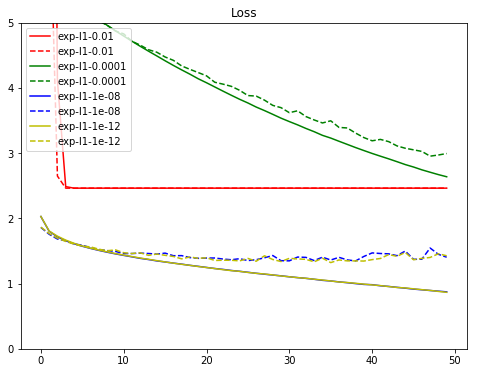

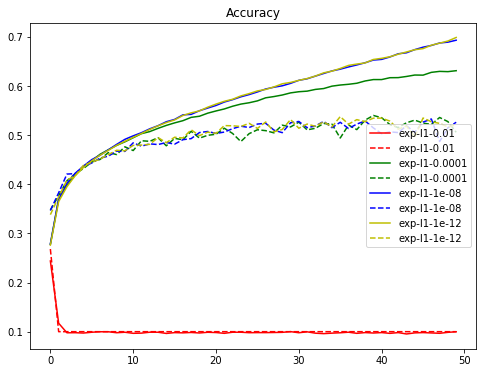

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()